Additionally, geographical data can be used to improve the similarity and clustering of the the languages. It stands to reason that languages whose geographical centers are nearer to each other will have their respective populations interact with each other more often, encouraging the exchange of phonology and shared concepts between the two languages. The effect of such interactions between two populations of a language may not be captured by a lexical analysis alone.

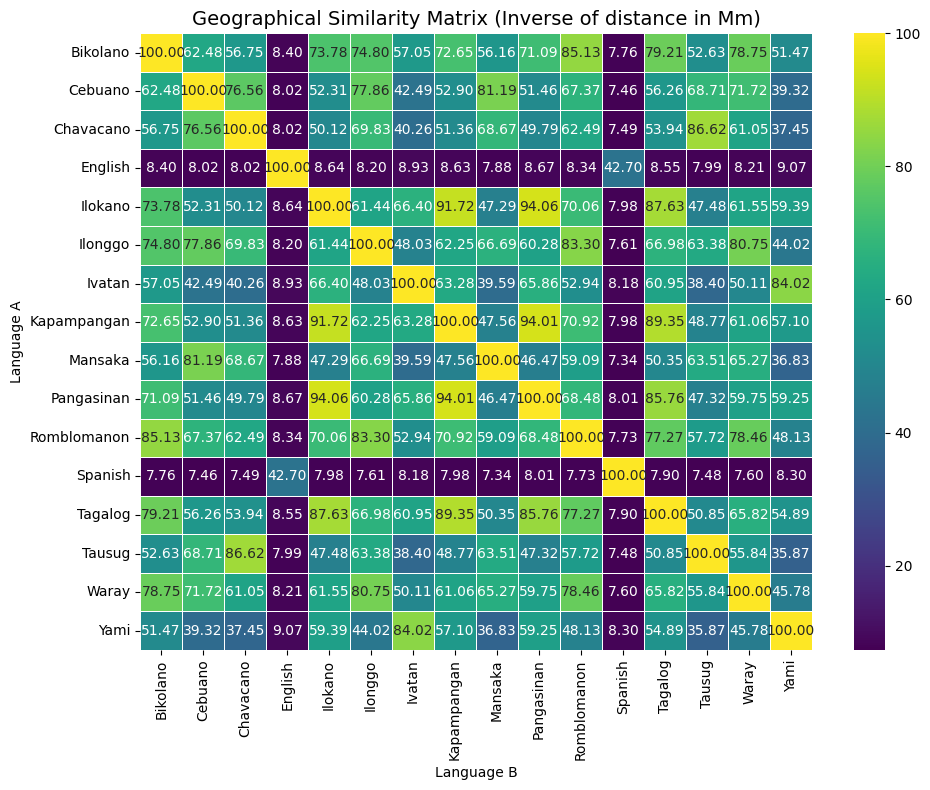

In [73]:
import pandas as pd
import numpy as np
import io
#!python -m pip install --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host=files.pythonhosted.org geopy
from geopy.distance import great_circle
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns

# Manually load the data because I have had it with these paths.
# These coordinates were obtained from each language's respective Ethnologue page
geo_csv_data = """
language,x,y
Bikolano,123.4033,13.7557
Cebuano,124.4179,8.448
Chavacano,122.0318,7.0362
English,-0.2397,52.2486
Ilokano,120.9751,15.9247
Ilonggo,123.2482,10.7304
Ivatan,121.9454,20.3815
Kapampangan,120.3393,15.3912
Mansaka,126.1601,7.28
Pangasinan,120.3852,15.962
Romblomanon,122.5741,12.4086
Spanish,-3.5465,40.3952
Tagalog,121.1581,14.6678
Tausug,121.127,5.9765
Waray,125.0539,11.9388
Yami,121.5444,22.05
"""

geo_data_file = io.StringIO(geo_csv_data)
geo_centers = pd.read_csv(geo_data_file, index_col=0)

languages = geo_centers.index.tolist()
geo_sim_matrix = pd.DataFrame(index=languages, columns=languages, dtype=float)

for lang_a, lang_b in product(languages, languages):
    # Retrieve coordinates. 'y' is latitude, 'x' is longitude.
    coords_1 = (geo_centers.loc[lang_a, 'y'], geo_centers.loc[lang_a, 'x'])
    coords_2 = geo_centers.loc[lang_b, 'y'], geo_centers.loc[lang_b, 'x']
    
    # Calculate similarity and populate matrix
    # Distance between two points on the globe is the great circle distance (in km) between the two points
    # The similarity is given as 100 / (1 + distance_km / 1000)
    # The numerator, 100, ensures that similarity scores are normalized between 0 and 100
    # The denominator uses the megameters for improved quality of the similarity score scale
    distance_km = great_circle(coords_1, coords_2).kilometers
    geo_sim_matrix.loc[lang_a, lang_b] = 100 / (1 + distance_km / 1000)
    geo_sim_matrix.loc[lang_b, lang_a] = 100 / (1 + distance_km / 1000)

geo_sim_matrix

plt.figure(figsize=(10, 8))
sns.heatmap(geo_sim_matrix.astype(float), annot=True, cmap="viridis", fmt=".2f", linewidths=.5)
plt.title("Geographical Similarity Matrix (Inverse of distance in Mm)", fontsize=14)
plt.xlabel("Language B")
plt.ylabel("Language A")
plt.tight_layout()
plt.show()

The similarity matrix of language geographic centers further emphasizes the difference between the European languages, namely, English and Spanish, and the Filipino languages. With the English language being centered in the United Kingdom, and the Spanish language in Spain, they are geographically centered very far compared to the Filipino languages. However, it is important to note that English's use across the globe as a lingua franca and Spanish's use in many different territotities makes it difficult to associate these languages with a single locality.

This matrix also captures important data that was missing from the lexical similarity matrix. In particular, Chavacano, whose lexical similarity score with Spanish was 81.09, has a geographical similarity score of 7.49 with the Spanish language. This drastic change in the two similarity scores represents two dimensions: the development of Chavacano in the proximity of other Philippine languages and its status as a Spanish creole.

These two similarity scores both describe the similarity of each language to every other language, but each similarity score represents different dimensions or attributes that two languages are similar/different in. One way to summarize these two scores is to apply a weight to each similarity score, representing how much influence each similarity score has on the final similarity score value. We set the weight of the lexical similarity score to be 0.75 while the geographical similarity score has a weight of 0.25.

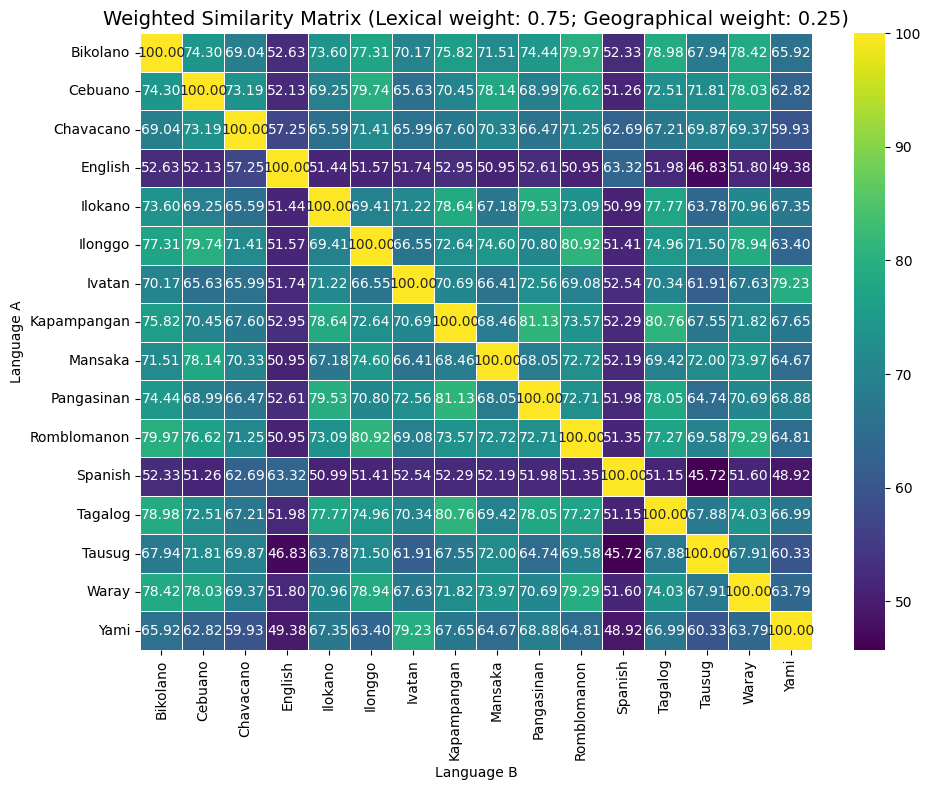

In [74]:
lex_csv_data = """ 
,Bikolano,Cebuano,Chavacano,English,Ilokano,Ilonggo,Ivatan,Kapampangan,Mansaka,Pangasinan,Romblomanon,Spanish,Tagalog,Tausug,Waray,Yami
Bikolano,100,78.24448414,73.13892489,67.37056297,73.54285479,78.14936806,74.54024176,76.87758815,76.62861237,75.55509239,78.24508864,67.18943689,78.90078314,73.03841473,78.30535036,70.73709295
Cebuano,78.24448414,100,72.06281526,66.83794336,74.90118385,80.36155195,73.34305135,76.29371644,77.12851527,74.83384917,79.70167274,65.86149695,77.92324809,72.84622092,80.13344827,70.6507277
Chavacano,73.13892489,72.06281526,100,73.65920998,70.7408352,71.93449908,74.56779944,73.01314192,70.87954378,72.03660605,74.17177678,81.09287359,71.63839324,64.2883581,72.14633623,67.41702642
English,67.37056297,66.83794336,73.65920998,100,65.70332587,66.0256516,66.00789201,67.7211275,65.30979793,67.2584132,65.14923786,70.19502187,66.46237879,59.77936551,66.32687257,62.81997263
Ilokano,73.54285479,74.90118385,70.7408352,65.70332587,100,72.0716639,72.8281539,74.28182495,73.81633726,74.68594674,74.10350457,65.32342458,74.47885555,69.21257977,74.08906793,70.00318451
Ilonggo,78.14936806,80.36155195,71.93449908,66.0256516,72.0716639,100,72.7198065,76.10764557,77.23074628,74.31115261,80.12247675,66.00610864,77.61520587,74.20160372,78.33470898,69.86429015
Ivatan,74.54024176,73.34305135,74.56779944,66.00789201,72.8281539,72.7198065,100,73.15689761,75.34423172,74.78947583,74.45630303,67.32780765,73.47169013,69.74623936,73.46991245,77.62727128
Kapampangan,76.87758815,76.29371644,73.01314192,67.7211275,74.28182495,76.10764557,73.15689761,100,75.42400908,76.83348766,74.45497297,67.06036491,77.90239536,73.80455621,75.40226513,71.16426533
Mansaka,76.62861237,77.12851527,70.87954378,65.30979793,73.81633726,77.23074628,75.34423172,75.42400908,100,75.23922203,77.26569073,67.14372109,75.77876428,74.82870633,76.86859268,73.95234402
Pangasinan,75.55509239,74.83384917,72.03660605,67.2584132,74.68594674,74.31115261,74.78947583,76.83348766,75.23922203,100,74.11543699,66.63762844,75.48384248,70.5532093,74.337498,72.0955431
Romblomanon,78.24508864,79.70167274,74.17177678,65.14923786,74.10350457,80.12247675,74.45630303,74.45497297,77.26569073,74.11543699,100,65.89609494,77.27592028,73.53362709,79.57310767,70.36985024
Spanish,67.18943689,65.86149695,81.09287359,70.19502187,65.32342458,66.00610864,67.32780765,67.06036491,67.14372109,66.63762844,65.89609494,100,65.56781954,58.46702748,66.2614732,62.46418784
Tagalog,78.90078314,77.92324809,71.63839324,66.46237879,74.47885555,77.61520587,73.47169013,77.90239536,75.77876428,75.48384248,77.27592028,65.56781954,100,73.56106683,76.77035227,71.02159684
Tausug,73.03841473,72.84622092,64.2883581,59.77936551,69.21257977,74.20160372,69.74623936,73.80455621,74.82870633,70.5532093,73.53362709,58.46702748,73.56106683,100,71.92996522,68.48703593
Waray,78.30535036,80.13344827,72.14633623,66.32687257,74.08906793,78.33470898,73.46991245,75.40226513,76.86859268,74.337498,79.57310767,66.2614732,76.77035227,71.92996522,100,69.78768495
Yami,70.73709295,70.6507277,67.41702642,62.81997263,70.00318451,69.86429015,77.62727128,71.16426533,73.95234402,72.0955431,70.36985024,62.46418784,71.02159684,68.48703593,69.78768495,100
"""

lex_data_file = io.StringIO(lex_csv_data)
lex_sim_matrix = pd.read_csv(lex_data_file, index_col=0)

percent_lex = 0.75

weighted_sim_matrix = lex_sim_matrix * percent_lex + (1 - percent_lex) * geo_sim_matrix

plt.figure(figsize=(10, 8))
sns.heatmap(weighted_sim_matrix.astype(float), annot=True, cmap="viridis", fmt=".2f", linewidths=.5)
plt.title(f"Weighted Similarity Matrix (Lexical weight: {percent_lex:.2f}; Geographical weight: {(1 - percent_lex):.2f})", fontsize=14)
plt.xlabel("Language B")
plt.ylabel("Language A")
plt.tight_layout()
plt.show()

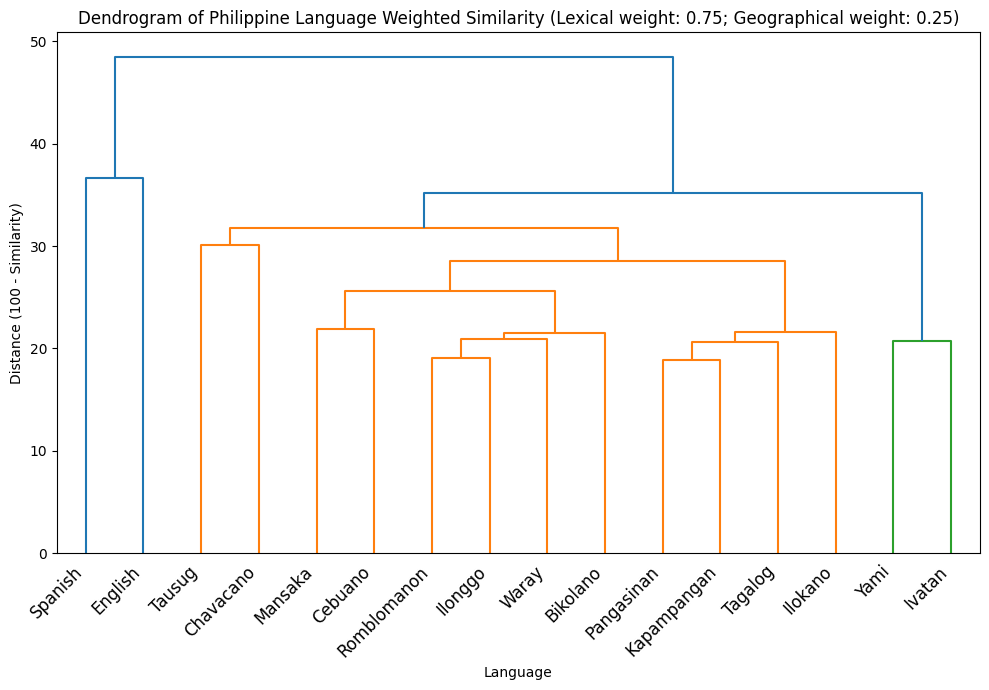

In [75]:
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform

# Convert similarity to distance
# Assuming 100% similarity means 0 distance
distance_matrix = 100 - weighted_sim_matrix

# Convert the distance matrix to a condensed distance matrix required by linkage
condensed_distance_matrix = squareform(distance_matrix)

linked = linkage(condensed_distance_matrix, 'weighted')

plt.figure(figsize=(10, 7))
dendrogram(linked,
           orientation='top',
           labels=languages,
           distance_sort='descending',
           show_leaf_counts=True)
plt.title(f'Dendrogram of Philippine Language Weighted Similarity (Lexical weight: {percent_lex:.2f}; Geographical weight: {(1 - percent_lex):.2f})')
plt.xlabel('Language')
plt.ylabel('Distance (100 - Similarity)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

We can also combine the geographical similarity of the languages with the similarities in the cosine similarity matrix that compared languages based on the distribution of trigrams to see what clusters will result from a finer look at the orthographics of the languages combined with geographical data.

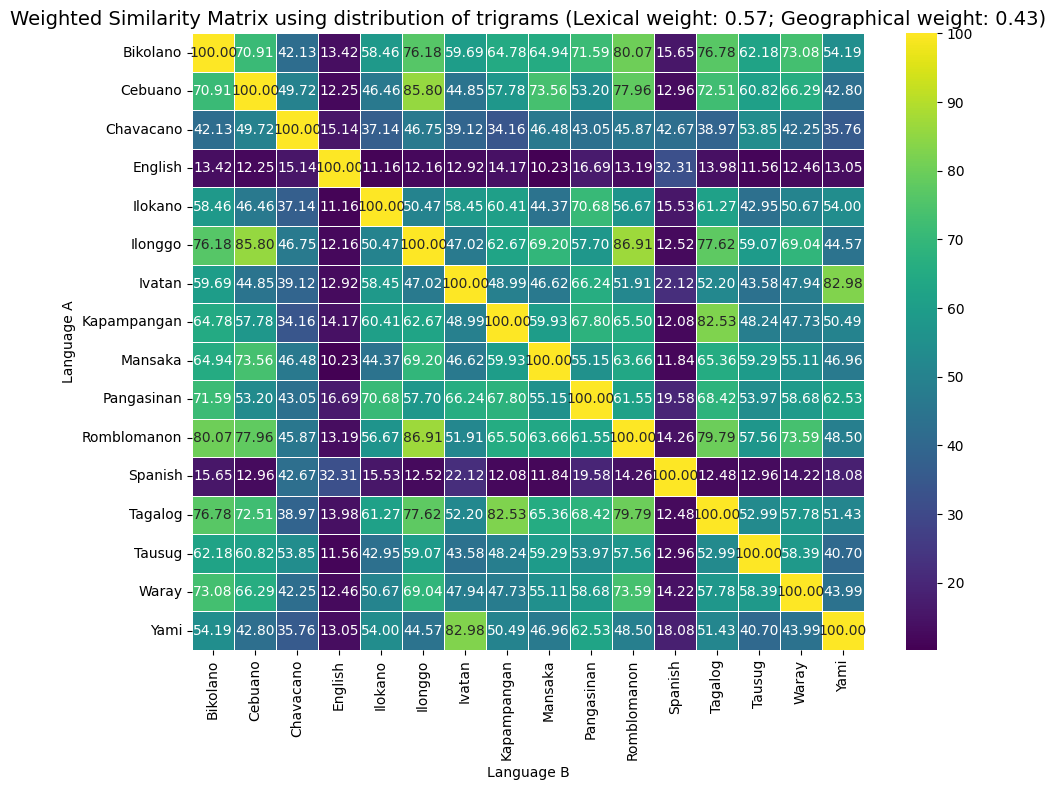

In [ ]:
cos_csv_data = """ 
,Bikolano,Cebuano,Chavacano,English,Ilokano,Ilonggo,Ivatan,Kapampangan,Mansaka,Pangasinan,Romblomanon,Spanish,Tagalog,Tausug,Waray,Yami
Bikolano,100,77.27051748,31.10085187,17.20363444,46.90900771,77.20933855,61.68618735,58.84769781,71.55309258,71.97303897,76.26014971,21.59303147,74.94183293,69.39143367,68.80993005,56.24431766
Cebuano,77.27051748,100,29.47316094,15.4472258,42.04372744,91.78653109,46.63439186,61.45866876,67.81121057,54.5088873,85.95135152,17.11150409,84.77145476,54.8725385,62.20197408,45.43292384
Chavacano,31.10085187,29.47316094,100,20.51665987,27.34499905,29.33829977,38.25652188,21.19499377,29.74867662,37.97478604,33.32944733,69.20955547,27.68391963,29.13945386,28.06086446,34.48489039
English,17.20363444,15.4472258,20.51665987,100,13.0530308,15.14082401,15.92340812,18.34588061,12.00233975,22.73164366,16.8464489,24.47987529,18.0716794,14.25548992,15.65725109,16.0536916
Ilokano,46.90900771,42.04372744,27.34499905,13.0530308,100,42.20163807,52.45241185,36.79886764,42.17366001,53.05036305,46.56898186,21.2301928,41.38501102,39.54016795,42.4516275,49.92614406
Ilonggo,77.20933855,91.78653109,29.33829977,15.14082401,42.20163807,100,46.26014992,62.98170412,71.08526361,55.75480471,89.62807272,16.22672028,85.64597438,55.82559168,60.20922123,44.99180099
Ivatan,61.68618735,46.63439186,38.25652188,15.92340812,52.45241185,46.26014992,100,38.21854813,51.92385394,66.51609102,51.13466183,32.63009468,45.60227628,47.49070114,46.30192677,82.19356904
Kapampangan,58.84769781,61.45866876,21.19499377,18.34588061,36.79886764,62.98170412,38.21854813,100,69.26331791,48.03021288,61.41445617,15.16945805,77.39226934,47.83105268,37.67588736,45.50404355
Mansaka,71.55309258,67.81121057,29.74867662,12.00233975,42.17366001,71.08526361,51.92385394,69.26331791,100,61.69513146,67.1052241,15.24640002,76.68702322,56.10066097,47.43647944,54.5991989
Pangasinan,71.97303897,54.5088873,37.97478604,22.73164366,53.05036305,55.75480471,66.51609102,48.03021288,61.69513146,100,56.31550585,28.30425248,55.33388621,58.9791545,57.86951411,65.01094388
Romblomanon,76.26014971,85.95135152,33.32944733,16.8464489,46.56898186,89.62807272,51.13466183,61.41445617,67.1052241,56.31550585,100,19.1836228,81.69507108,57.44732915,69.92550597,48.77751019
Spanish,21.59303147,17.11150409,69.20955547,24.47987529,21.2301928,16.22672028,32.63009468,15.16945805,15.24640002,28.30425248,19.1836228,100,15.93937868,17.09944107,19.20442646,25.45278598
Tagalog,74.94183293,84.77145476,27.68391963,18.0716794,41.38501102,85.64597438,45.60227628,77.39226934,76.68702322,55.33388621,81.69507108,15.93937868,100,54.59780163,51.71999601,48.82034765
Tausug,69.39143367,54.8725385,29.13945386,14.25548992,39.54016795,55.82559168,47.49070114,47.83105268,56.10066097,58.9791545,57.44732915,17.09944107,54.59780163,100,60.32084555,44.3466646
Waray,68.80993005,62.20197408,28.06086446,15.65725109,42.4516275,60.20922123,46.30192677,37.67588736,47.43647944,57.86951411,69.92550597,19.20442646,51.71999601,60.32084555,100,42.64097423
Yami,56.24431766,45.43292384,34.48489039,16.0536916,49.92614406,44.99180099,82.19356904,45.50404355,54.5991989,65.01094388,48.77751019,25.45278598,48.82034765,44.3466646,42.64097423,100

"""

cos_data_file = io.StringIO(cos_csv_data)
cos_sim_matrix = pd.read_csv(cos_data_file, index_col=0)

# Decreased weight of trigram distribution until Chavacano was correctly clustered with other Filipino languages
percent_cos = 0.57

weighted_sim_matrix_2 = cos_sim_matrix * percent_cos + (1 - percent_cos) * geo_sim_matrix

plt.figure(figsize=(10, 8))
sns.heatmap(weighted_sim_matrix_2.astype(float), annot=True, cmap="viridis", fmt=".2f", linewidths=.5)
plt.title(f"Weighted Similarity Matrix using distribution of trigrams (Lexical weight: {percent_cos:.2f}; Geographical weight: {(1 - percent_cos):.2f})", fontsize=14)
plt.xlabel("Language B")
plt.ylabel("Language A")
plt.tight_layout()
plt.show()

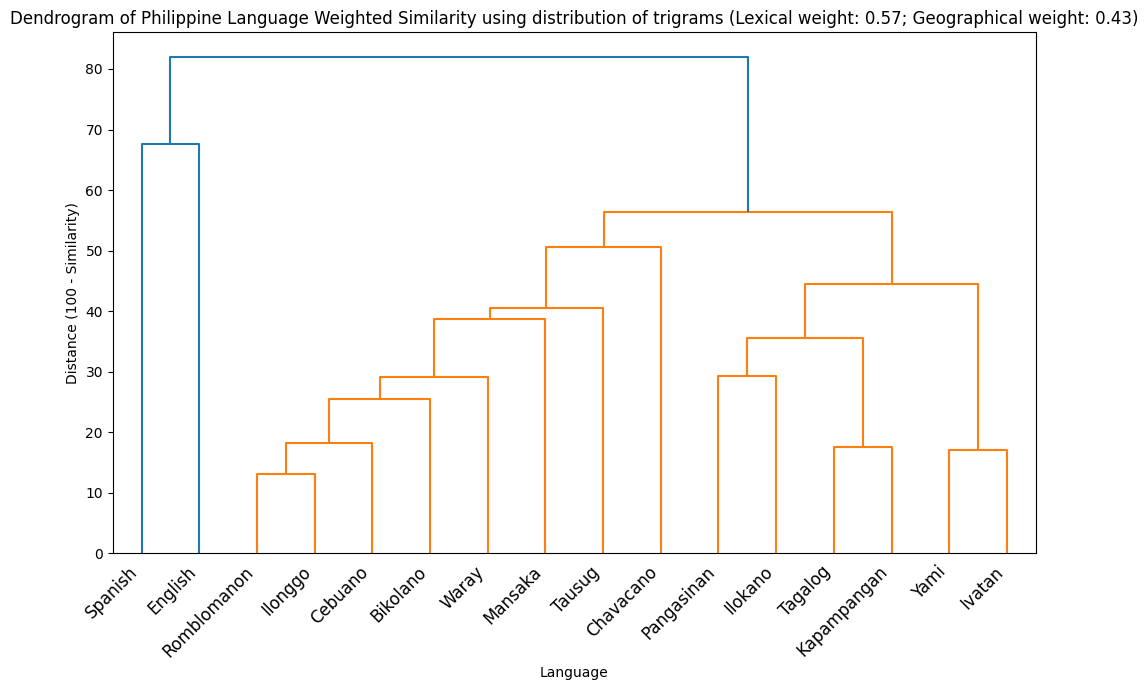

In [77]:
# Convert similarity to distance
# Assuming 100% similarity means 0 distance
distance_matrix = 100 - weighted_sim_matrix_2

# Convert the distance matrix to a condensed distance matrix required by linkage
condensed_distance_matrix = squareform(distance_matrix)

linked = linkage(condensed_distance_matrix, 'weighted')

plt.figure(figsize=(10, 7))
dendrogram(linked,
           orientation='top',
           labels=languages,
           distance_sort='descending',
           show_leaf_counts=True)
plt.title(f'Dendrogram of Philippine Language Weighted Similarity using distribution of trigrams (Lexical weight: {percent_cos:.2f}; Geographical weight: {(1 - percent_cos):.2f})')
plt.xlabel('Language')
plt.ylabel('Distance (100 - Similarity)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()